# This notebook calls to the google directions api

In [2]:
# load necessary modules
import requests
import json
import polyline
import geopandas as gpd
from matplotlib import pyplot as plt
%matplotlib inline
from shapely.geometry import LineString, Point
import pandas as pd
from weather import get_weather
from datetime import datetime

ModuleNotFoundError: No module named 'weather'

In [96]:
def query_api(secret_loc, start_loc, end_loc):
    base_url = 'https://maps.googleapis.com/maps/api/directions/json?mode=walking'
    with open(secret_loc, "r") as f:
        key = json.load(f)['key']
    url = f"{base_url}&origin={start_loc}&destination={end_loc}&key={key}"
    response = requests.get(url)
    print(response.status_code, response.reason)
    print(response.text)
    return response
    

In [98]:
def extract_route_and_warnings(response_json):
    """extracts route and warnings from google directions API response
    
    args:
        response_json: the json of the google directions API response
    
    returns:
        rte: route as a geopandas dataframe with columns: longitude, latitude, geometry 
        warn: warnings for display
    """
    goog_polyline = response_json['overview_polyline']
    warn = response_json['warnings']
    rte = pd.DataFrame(polyline.decode(goog_polyline, geojson=True), columns=['longitude', 'latitude'])
    rte = gpd.GeoDataFrame(rte, geometry=gpd.points_from_xy(rte['longitude'], rte['latitude']))
    rte = LineString([[p.x, p.y] for p in rte['geometry']])
    return rte, warn

In [ ]:
def get_route(secret_loc, start_loc, end_loc):
    """Calls to Google Service API to return the recommended route.
    
    Args:
        secret_loc: location of file with api key
        start_loc: starting location of the desired walk 
            (lat,long stringw/out spaces)
        end_loc: ending location of the desired walk 
            (lat,long string w/out spaces)
        
    Returns:
        route: shapely line of the recommended path
        warn: route-related warnings for display
    """
    response = query_api(secret_loc, start_loc, end_loc)
    resp_json = json.loads(response.text)
    route, warnings = extract_route_and_warnings(resp_json)
    return route, warning
    
    
    

In [ ]:
secret_location_goog = 'Users/allisonhonold/.secrets/google_maps_api.json'
secret_loc_weather = "/Users/allisonhonold/.secrets/dark_sky_api.json"
with open(secret_loc, "r") as f:
    weather_key = json.load(f)["key"]
start_loc = '40.723011,-73.990142'
end_loc = '40.729625,-73.991106'
route, warning = get_route(secret_location, start_loc, end_loc)
today = #get today's date from comp
(start_lat, start_long) = start_loc.split() #split on comma
weather = get_weather(start_loc, today)


In [59]:
path = [(-73.968, 40.7647),
 (-73.9713, 40.76622),
 (-73.9711, 40.7665)]

In [60]:
practice = gpd.GeoDataFrame(path)

In [61]:
practice.head()

,0,1
0,-73.9680,40.76470
1,-73.9713,40.76622
2,-73.9711,40.76650


In [62]:
practice = gpd.GeoDataFrame(practice, geometry=gpd.points_from_xy(practice[0], practice[1]))

In [63]:
practice.head()

,0,1,geometry
0,-73.9680,40.76470,POINT (-73.96800 40.76470)
1,-73.9713,40.76622,POINT (-73.97130 40.76622)
2,-73.9711,40.76650,POINT (-73.97110 40.76650)


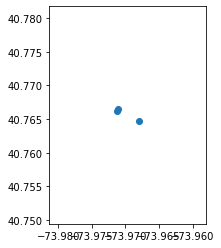

In [64]:
practice.plot()

In [74]:
practice_poly = LineString([[p.x, p.y] for p in practice['geometry']])

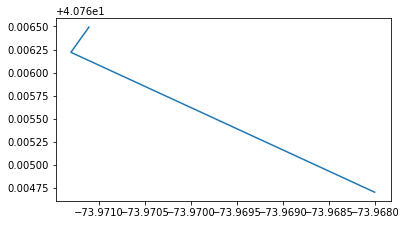

In [75]:
gpd.GeoSeries(practice_poly).plot()

In [67]:
from haversine import haversine, Unit
from shapely.ops import nearest_points
from itertools import product
import numpy as np

In [85]:
def create_pt_grid(minx, miny, maxx, maxy):
    n_lats = round((maxy-miny)/.001) +1
    lats = np.linspace(miny, maxy, n_lats)
    n_longs = round((maxx - minx)/.001) +1
    longs = np.linspace(minx, maxx, n_longs)
    lat_long_df = pd.DataFrame(product(lats, longs), columns=['latitude', 'longitude'])
    geo_df = gpd.GeoDataFrame(lat_long_df,
                         geometry=gpd.points_from_xy(lat_long_df['longitude'], lat_long_df['latitude']))
    return geo_df
    

In [86]:
def on_path(geom_series, dist, line):
    on_path = []
    for index in geom_series.index:
        x = geom_series[index].x
        y = geom_series[index].y
        pt1, ln_pt = nearest_points(Point(x, y), line)
        on_path.append(haversine((pt1.y, pt1.x), (ln_pt.y, ln_pt.x), unit='ft') < dist)
    return on_path
    

In [87]:
# get line bounds
# add a buffer to the line bounds
# create df of all points w/in the bounds
# for each point:
#    check if nearest points (shapely.ops.nearest_points(geom1, geom2)) 
#    are w/in haversine distance 500 ft
def get_pts_near_path(line, distance):
    # get line bounds
    (minx, miny, maxx, maxy) = line.bounds
    
    # extract values with buffer area
    minx = round(minx, 3) -0.002
    miny = round(miny, 3) -0.002
    maxx = round(maxx, 3) + 0.002
    maxy = round(maxy, 3) + 0.002
    
    # create a df of all lat, longs w/in bounds
    all_pts = create_pt_grid(minx, miny, maxx, maxy)
    
    all_pts['on_path'] = on_path(all_pts['geometry'], distance, line)
    return all_pts.loc[all_pts['on_path']==True]

In [93]:
pts = get_pts_near_path(practice_poly, 750)

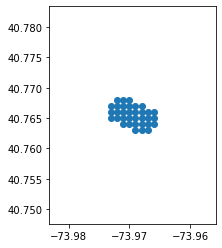

In [92]:
pts.plot()

## investigate missing locations in man_lat_longs.csv

In [3]:
lat_longs = pd.read_csv('/Users/allisonhonold/ds0805/walk_proj/walk_risk_engine/data/csv/man_lat_longs.csv')

In [6]:
lat_longs.head()

,Unnamed: 0,latitude,longitude,geometry,in_man
0,170,40.683,-74.023,POINT (-74.02300000000001 40.683),True
1,313,40.684,-74.024,POINT (-74.024 40.684),True
2,325,40.684,-74.012,POINT (-74.012 40.684),True
3,455,40.685,-74.026,POINT (-74.02600000000001 40.685),True
4,456,40.685,-74.025,POINT (-74.02500000000001 40.685),True


In [16]:
lat_longs.loc[(lat_longs['latitude'] == 40.753) & (lat_longs['longitude'] == -73.989)]

,Unnamed: 0,latitude,longitude,geometry,in_man
